## Sentinel-2 vegetation indices over Camargue with plot on Map

### Introduction

The spectral bands of Sentinel-2 MSI are:

| S-2 band                | 1   | 2   | 3   | 4   | 5   | 6   | 7   | 8   | 8a  | 9   | 10   | 11   | 12   |
|-------------------------|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|------|------|------|
| Central wavelength (nm) | 443 | 490 | 560 | 665 | 705 | 740 | 783 | 842 | 865 | 945 | 1375 | 1610 | 2190 |
| Bandwidth (nm)          | 20  | 65  | 35  | 30  | 15  | 15  | 20  | 115 | 20  | 20  | 30   | 90   | 180  |
| Spatial resolution (m)  | 60  | 10  | 10  | 10  | 20  | 20  | 20  | 10  | 20  | 60  | 60   | 20   | 20   |

Several vegetation indices can be calculated, the table below defines a few of those indices:

| Vegetation index | Formulation     | S-2 bands used      |
|------------------|-----------------|---------------------|
| NDVI             | (NIR-R)/(NIR+R) | (B7 − B4)/(B7 + B4) |
| NDI45            | (NIR-R)/(NIR+R) | (B5 − B4)/(B5 + B4) |
| GNDVI            | (NIR−G)/(NIR+G) | (B7 − B3)/(B7 − B3) |

This notebook shows how to calculate and plot these indices using Snappy.

### Implementation

Import all libraries needed:

In [85]:
from snappy import jpy
from snappy import GPF
from snappy import HashMap
from snappy import ProductIO
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import json
import ipywidgets
import ipyleaflet as ll

%matplotlib inline

We will use a Sentinel-2 product with a single granule:

In [86]:
s2path = "data/S2A_OPER_PRD_MSIL1C_PDMC_20151230T202002_R008_V20151230T105153_20151230T105153"
s2meta = "S2A_OPER_MTD_SAFL1C_PDMC_20151230T202002_R008_V20151230T105153_20151230T105153"

Open the product and get some information about it

In [87]:
s2prd = "%s.SAFE/%s.xml" % (s2path, s2meta)
reader = ProductIO.getProductReader("SENTINEL-2-MSI-60M-UTM31N")
product = reader.readProductNodes(s2prd, None)

width = product.getSceneRasterWidth()
height = product.getSceneRasterHeight()
name = product.getName()
description = product.getDescription()
band_names = product.getBandNames()

In [88]:
print("Product: %s, %d x %d pixels" % (name, width, height))

Product: S2A_OPER_MTD_SAFL1C_PDMC_20151230T202002_R008_V20151230T105153_20151230T105153, 1830 x 1830 pixels


In [89]:
print(product.getSceneGeoCoding())

org.esa.snap.core.datamodel.CrsGeoCoding@398f6622

Map CRS:
PROJCS["WGS 84 / UTM zone 31N", 
  GEOGCS["WGS 84", 
    DATUM["World Geodetic System 1984", 
      SPHEROID["WGS 84", 6378137.0, 298.257223563, AUTHORITY["EPSG","7030"]], 
      AUTHORITY["EPSG","6326"]], 
    PRIMEM["Greenwich", 0.0, AUTHORITY["EPSG","8901"]], 
    UNIT["degree", 0.017453292519943295], 
    AXIS["Geodetic latitude", NORTH], 
    AXIS["Geodetic longitude", EAST], 
    AUTHORITY["EPSG","4326"]], 
  PROJECTION["Transverse_Mercator", AUTHORITY["EPSG","9807"]], 
  PARAMETER["central_meridian", 3.0], 
  PARAMETER["latitude_of_origin", 0.0], 
  PARAMETER["scale_factor", 0.9996], 
  PARAMETER["false_easting", 500000.0], 
  PARAMETER["false_northing", 0.0], 
  UNIT["m", 1.0], 
  AXIS["Easting", EAST], 
  AXIS["Northing", NORTH], 
  AUTHORITY["EPSG","32631"]]
Image To Map:
AffineTransform[[60.0, 0.0, 600000.0], [0.0, -60.0, 4900020.0]]


#### List the band names to create the arithmetic expressions

In [90]:
print("Bands:   %s" % (list(band_names)))

Bands:   ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B10', 'B11', 'B12', 'sun_zenith', 'sun_azimuth', 'view_zenith', 'view_azimuth']


## Reproject to EPSG:4326

In [91]:
GPF.getDefaultInstance().getOperatorSpiRegistry().loadOperatorSpis()

HashMap = jpy.get_type('java.util.HashMap')
pars = HashMap()
pars.put('crs', "EPSG:4326")

In [92]:
res1  = GPF.createProduct('Reproject', pars, product)

#### Create the band arithmetic expressions

In [93]:
ndvi_expr = '(B7 + B4) != 0 ? (B7 - B4) / (B7 + B4) : -2'
ndi45_expr = '(B5 + B4) != 0 ? (B5 - B4) / (B5 + B4) : -2'
gndvi_expr = '(B7 + B3) != 0 ? (B7 - B3) / (B7 + B3) : -2'

Use the SNAP _BandMaths_ operator:

In [94]:
GPF.getDefaultInstance().getOperatorSpiRegistry().loadOperatorSpis()

HashMap = jpy.get_type('java.util.HashMap')
BandDescriptor = jpy.get_type('org.esa.snap.core.gpf.common.BandMathsOp$BandDescriptor')

In [95]:
targetBand1 = BandDescriptor()
targetBand1.name = 'ndvi'
targetBand1.type = 'float32'
targetBand1.expression = ndvi_expr

targetBand2 = BandDescriptor()
targetBand2.name = 'ndi45'
targetBand2.type = 'float32'
targetBand2.expression = ndi45_expr

targetBand3 = BandDescriptor()
targetBand3.name = 'gndvi'
targetBand3.type = 'float32'
targetBand3.expression = gndvi_expr

targetBands = jpy.array('org.esa.snap.core.gpf.common.BandMathsOp$BandDescriptor', 3)
targetBands[0] = targetBand1
targetBands[1] = targetBand2
targetBands[2] = targetBand3

parameters = HashMap()
parameters.put('targetBands', targetBands)

In [96]:
result = GPF.createProduct('BandMaths', parameters, res1)

In [97]:
a = res1.getSceneGeoCoding()
print(a)


org.esa.snap.core.datamodel.CrsGeoCoding@2087181d

Map CRS:
GEOGCS["WGS 84", 
  DATUM["World Geodetic System 1984", 
    SPHEROID["WGS 84", 6378137.0, 298.257223563, AUTHORITY["EPSG","7030"]], 
    AUTHORITY["EPSG","6326"]], 
  PRIMEM["Greenwich", 0.0, AUTHORITY["EPSG","8901"]], 
  UNIT["degree", 0.017453292519943295], 
  AXIS["Geodetic longitude", EAST], 
  AXIS["Geodetic latitude", NORTH], 
  AUTHORITY["EPSG","4326"]]
Image To Map:
AffineTransform[[5.5212987354E-4, 0.0, 4.232407673734831], [0.0, -5.5212987354E-4, 44.246276785620445]]


### Plot the vegetation indices

We will use _matplotlib_ for plotting the vegetation indices


In [98]:
band1 = result.getBand('ndvi')
band2 = result.getBand('ndi45')
band3 = result.getBand('gndvi')

w = band1.getRasterWidth()
h = band1.getRasterHeight()

band1_data = np.zeros(w * h, np.float32)
band1.readPixels(0, 0, w, h, band1_data)

band2_data = np.zeros(w * h, np.float32)
band2.readPixels(0, 0, w, h, band2_data)

band3_data = np.zeros(w * h, np.float32)
band3.readPixels(0, 0, w, h, band3_data)

product.dispose()
result.dispose()

band1_data.shape = h, w
band2_data.shape = h, w
band3_data.shape = h, w

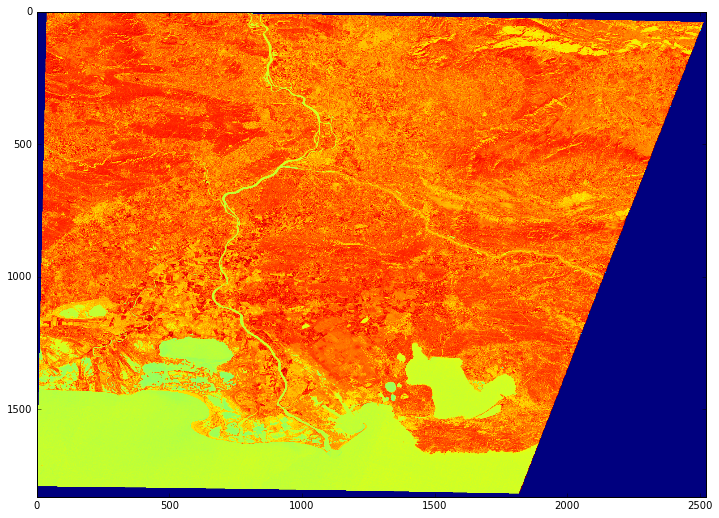

In [114]:
plt.figure(figsize=(12, 12))
imgplot = plt.imshow(band1_data)
imgplot.write_png('outputs/ndvi.png')

In [115]:
from PIL import Image
img = Image.open('outputs/ndvi.png')
mirror = img.transpose(Image.FLIP_LEFT_RIGHT).transpose(Image.ROTATE_180)
mirror.save('outputs/ndvi-ll.png')

resolution = 5.5212987354E-4
lon_min = 4.232407673734831
lat_max = 44.246276785620445

lon_max = lon_min + resolution * res1.getSceneRasterWidth() 
lat_min = lat_max - resolution * res1.getSceneRasterHeight()  

lay = ll.ImageOverlay(url='outputs/ndvi-ll.png', bounds=[[lat_min,lon_min], [lat_max,lon_max]])
map = ll.Map(center=[43.08,6.34], zoom=6)
map.add_layer(lay)
map